## Web Crawling
- 웹 페이지에서 데이터를 수집하는 방법에 대해서 학습

### 웹크롤링 방법

#### 웹페이지의 종류
- 정적인 페이지 : 웹 브라우져에 화면이 한번 뜨면 이벤트에 의한 화면의 변경이 없는 페이지 
- 동적인 페이지 : 웹 브라우져에 화면이 뜨고 이벤트가 발생하면 서버에서 데이터를 가져와 화면을 변경하는 페이지

#### requests 이용
- 받아오는 문자열에 따라 두가지 방법으로 구분
    - json 문자열로 받아서 파싱하는 방법 : 주로 동적 페이지 크롤링할때 사용 
    - html 문자열로 받아서 파싱하는 방법 : 주로 정적 페이지 크롤링할때 사용
        
#### selenium 이용
- 브라우져를 직접 열어서 데이터를 받는 방법

#### 크롤링 방법에 따른 속도
- requests json > requests html > selenium

### Crawling Naver Stock Data
- 네이버 증권 사이트에서 주가 데이터 수집
- 수집할 데이터 : 일별 kospi, kosdaq 주가, 일별 환율(exchange rate) 데이터
- 데이터 수집 절차
    - 웹서비스 분석 : url : chrome devtool
    - 서버에 데이터 요청 : request(url) > response : json(str)
    - 서버에서 받은 데이터 파싱(데이터 형태를 변경) : json(str) > list, dict > DataFrame

In [1]:
import requests
import pandas as pd

#### 1. 웹서비스 분석 : url
- pc 웹페이지가 복잡하면 mobile 웹페이지에서 수집

In [4]:
page_size, page = 60, 1
url = f'https://m.stock.naver.com/api/index/KOSPI/price?pageSize={page_size}&page={page}'
url

'https://m.stock.naver.com/api/index/KOSPI/price?pageSize=60&page=1'

#### 2. 서버에 데이터 요청 : request(url) > response : json(str)
- response의 status code가 200이 나오는지 확인
- 403이나 500이 나오면 request가 잘못되거나 web server에서 수집이 안되도록 설정이 된것임
    - header 설정 또는 selenium 사용
- 200이 나오더라도 response 안에 있는 내용을 확인 > 확인하는 방법 : response.text

In [7]:
response = requests.get(url)
response

<Response [200]>

In [9]:
type(response)

requests.models.Response

In [11]:
type(response.text), response.text[:100]

(str,
 '[{"localTradedAt":"2024-09-20","closePrice":"2,606.94","compareToPreviousClosePrice":"26.14","compar')

In [13]:
# dir(response)

#### 3. 서버에서 받은 데이터 파싱(데이터 형태를 변경) : json(str) > list, dict > DataFrame

In [16]:
data = response.json()
# type(data), data[:2]

In [18]:
df = pd.DataFrame(data)
df = df[['localTradedAt', 'closePrice']]
df.head(2)

,localTradedAt,closePrice
0,2024-09-20,"2,606.94"
1,2024-09-19,"2,580.80"


#### 4. 함수로 만들기

In [44]:
def stock_price(code='KOSPI', page=1, page_size=60):
    url = f'https://m.stock.naver.com/api/index/{code}/price?pageSize={page_size}&page={page}'
    response = requests.get(url)
    data = response.json()
    return pd.DataFrame(data)[['localTradedAt', 'closePrice']]

In [46]:
# https://m.stock.naver.com/api/index/KOSDAQ/price?pageSize=10&page=2

In [48]:
stock_price('KOSDAQ', 3, 5)

,localTradedAt,closePrice
0,2024-09-03,760.37
1,2024-09-02,769.21
2,2024-08-30,767.66
3,2024-08-29,756.04
4,2024-08-28,762.50


#### 5. 원달러 환율 데이터 수집 : 실습

In [145]:
# 1. URL
page_size, page = 60, 1
url = f'https://m.stock.naver.com/front-api/marketIndex/prices?\
category=exchange&reutersCode=FX_USDKRW&page={page}&pageSize={page_size}'
# 2. request(URL) > response(JSON)
response = requests.get(url)
# 3. JSON > list, dict > DataFrame
data = response.json()['result']
df = pd.DataFrame(data)[['localTradedAt', 'closePrice']]
df.tail(2)

,localTradedAt,closePrice
58,2024-06-26,"1,394.50"
59,2024-06-25,"1,392.00"


In [94]:
def exchange_rate(code='FX_USDKRW', page=1, page_size=60):
    url = f'https://m.stock.naver.com/front-api/marketIndex/prices?\
category=exchange&reutersCode={code}&page={page}&pageSize={page_size}'
    response = requests.get(url)
    data = response.json()['result']
    return pd.DataFrame(data)[['localTradedAt', 'closePrice']]

In [96]:
exchange_rate(page_size=10).tail(2)

,localTradedAt,closePrice
8,2024-09-05,"1,335.00"
9,2024-09-04,"1,336.50"


#### 6. 시각화

In [129]:
# 데이터 수집
page_size = 30
kp_df = stock_price('KOSPI', page_size=page_size)
kd_df = stock_price('KOSDAQ', page_size=page_size)
usd_df = exchange_rate(page_size=page_size)

# 데이터 전처리
kp_df['closePrice'] = kp_df['closePrice'].apply(lambda data: float(data.replace(',', '')))
kd_df['closePrice'] = kd_df['closePrice'].apply(lambda data: float(data.replace(',', '')))
usd_df['closePrice'] = usd_df['closePrice'].apply(lambda data: float(data.replace(',', '')))

In [163]:
kp_df['localTradedAt'][::5]

0     2024-09-20
5     2024-09-10
10    2024-09-03
15    2024-08-27
20    2024-08-20
25    2024-08-12
Name: localTradedAt, dtype: object

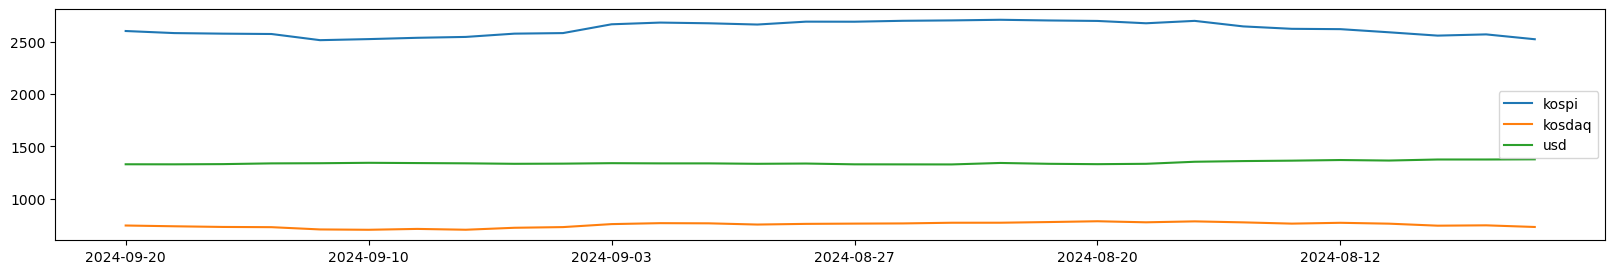

In [165]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 3))
plt.plot(kp_df['localTradedAt'], kp_df['closePrice'], label='kospi')
plt.plot(kd_df['localTradedAt'], kd_df['closePrice'], label='kosdaq')
plt.plot(usd_df['localTradedAt'], usd_df['closePrice'], label='usd')
plt.xticks(kp_df['localTradedAt'][::5])
plt.legend()
plt.show()

#### 7. 데이터 스케일링
- min max scaling


- $z = \frac{x_i - min(x)}{max(x) - min(x)} (0 \leqq z \leqq 1)$


- latex syntax : `https://jjycjnmath.tistory.com/117`

In [167]:
from sklearn.preprocessing import minmax_scale

In [169]:
minmax_scale(kp_df['closePrice'])

array([0.448842  , 0.34704066, 0.31930005, 0.30221307, 0.        ,
       0.0517756 , 0.11610911, 0.15908389, 0.31976325, 0.34704066,
       0.77848688, 0.86273803, 0.82830674, 0.76639218, 0.90818322,
       0.90519815, 0.95028307, 0.96922285, 1.        , 0.96634071,
       0.94318065, 0.82856408, 0.94626866, 0.6748842 , 0.55651055,
       0.54004117, 0.38630983, 0.22316006, 0.28327329, 0.04518785])

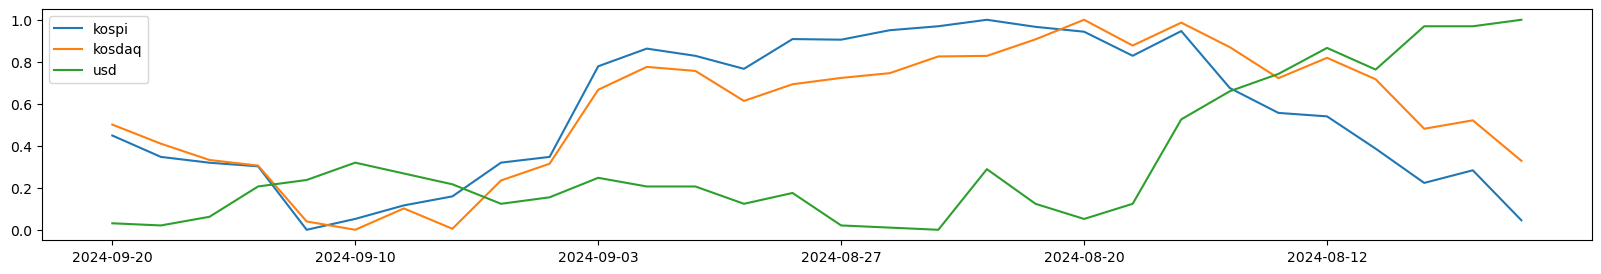

In [173]:
plt.figure(figsize=(20, 3))
plt.plot(kp_df['localTradedAt'], minmax_scale(kp_df['closePrice']), label='kospi')
plt.plot(kd_df['localTradedAt'], minmax_scale(kd_df['closePrice']), label='kosdaq')
plt.plot(usd_df['localTradedAt'], minmax_scale(usd_df['closePrice']), label='usd')
plt.xticks(kp_df['localTradedAt'][::5])
plt.legend()
plt.show()

#### 8. 상관관계 분석
- 피어슨 상관계수(Pearson Correlation Coefficient)
- 두 데이터 집합의 상관도를 분석할때 사용되는 지표
- 상관계수의 해석
    - -1에 가까울수록 서로 반대방향으로 움직임
    - 1에 가까울수록 서로 같은방향으로 움직임
    - 0에 가까울수록 두 데이터는 관계가 없음

In [183]:
# 데이터 전처리 : merge
merge_df = pd.merge(kp_df, kd_df, on='localTradedAt')
merge_df = pd.merge(merge_df, usd_df, on='localTradedAt')
merge_df.columns = ['date', 'kospi', 'kosdaq', 'usd']
merge_df.tail(2)

,date,kospi,kosdaq,usd
28,2024-08-07,2568.41,748.54,1376.0
29,2024-08-06,2522.15,732.87,1377.5


In [189]:
merge_df.iloc[:, 1:].corr()

,kospi,kosdaq,usd
kospi,1.000000,0.881514,-0.356399
kosdaq,0.881514,1.000000,0.029723
usd,-0.356399,0.029723,1.000000


In [ ]:
# 원달러환율이 높으면 달러를 원화로 환전하여 코스피 지수를 구매
# 원달러환율이 낮으면 코스피 지수를 판매하여 달러로 환전